# Clustering via Gausian Mixtures

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

file_path_PCA = "../../reduced_data/pca/embeddings/joueurs_ligue1_PCA_custom.csv"
file_path_tSNE = "../../reduced_data/tsne/embeddings/joueurs_ligue1_tSNE_custom_GK.csv"
file_path_ISOMAP = "../../reduced_data/isomap/embeddings/joueurs_ligue1_ISOMap_raw.csv"
file_path_UMAP = "../../reduced_data/umap/embeddings/joueurs_ligue1_2024_2025_clean_per90_umap5d_best_embedding.csv"

data_PCA= pd.read_csv(file_path_PCA, encoding="utf-8")
data_tSNE = pd.read_csv(file_path_tSNE, encoding="utf-8")
data_ISOMAP = pd.read_csv(file_path_ISOMAP, encoding="utf-8")
data_UMAP = pd.read_csv(file_path_UMAP, encoding="utf-8")
print(data_UMAP.head(1))

   UMAP_1    UMAP_2     UMAP_3     UMAP_4    UMAP_5    player_name  equipe  \
0   6.495  6.823001  18.643335  11.675789 -0.964921  Jordan Lefort  Angers   

  positions   age player_id player_country_code  
0        DF  30.0  c3e4ecbb                 FRA  


## Data Preparation : standardisation + columns removal

In [3]:
X_PCA = data_PCA.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_tSNE = data_tSNE.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_ISOMAP = data_ISOMAP.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_UMAP = data_UMAP.drop(columns=['player_name', 'equipe', 'positions','player_id','player_country_code', 'age']).copy()

scaler = StandardScaler()
X_PCA = scaler.fit_transform(X_PCA) 
X_tSNE = scaler.fit_transform(X_tSNE)
X_ISOMAP = scaler.fit_transform(X_ISOMAP) 
X_UMAP = scaler.fit_transform(X_UMAP) 
print(X_PCA[1])

[ 0.56743666  0.1044818   0.11736475  1.46994306 -1.18508298 -0.90158078
  2.80136953  0.79697642 -0.48612876 -0.08026856  0.18905473  0.29270347
  0.07825119  0.43794519 -0.29310798 -0.34096316 -0.21332355  0.26525129
  1.31121381 -0.8077366   0.29055237 -0.05780127  0.30848187  0.84052315
 -0.67780731 -0.71694207  0.92552594 -0.98482329 -0.11390012  0.69540283
 -0.78968318  0.68479298  0.74040084 -1.54720902]


## GridSearch Analysis

In [5]:
def gmm_gridsearch(X, n_components_range=range(2, 8), cov_types=['full','tied','diag','spherical'], random_state=42, verbose=True):
    results = []

    for n in n_components_range:
        for cov in cov_types:
            gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=random_state)
            gmm.fit(X)
            labels = gmm.predict(X)

            bic = gmm.bic(X)
            aic = gmm.aic(X)
            #resposabilites = gmm.predict_proba(X)
            convergence = gmm.converged_

            try:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            except Exception as e:
                sil_score = np.nan
                db_score = np.nan
                ch_score = np.nan
            results.append(
                'n_components': n,
                'covariance_type': cov,
                'BIC': bic,
                'AIC': aic,
                'silhouette_score': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score,
                #'resposabilites': resposabilites,
                'converged': convergence
            })

    results_df = pd.DataFrame(results)

    metrics = ['BIC', 'AIC', 'silhouette_score', 'davies_bouldin', 'calinski_harabasz']
    pivot_df = results_df.pivot(index='n_components', columns='covariance_type')[metrics]

    flat_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
    flat_df.columns = [f"{cov}_{metric}" for cov, metric in flat_df.columns]

    # Classements sur chaque indicateur
    rank_df = pd.DataFrame(index=flat_df.index)

    for col in flat_df.columns:
        metric = col.split("_", 1)[1]
        if metric in ['BIC', 'AIC', 'davies_bouldin']:
            rank_df[col] = flat_df[col].rank(method='min', ascending=True)
        else:
            rank_df[col] = flat_df[col].rank(method='min', ascending=False)

    # Moyenne qualité de modélisation (AIC + BIC)
    model_cols = [col for col in rank_df.columns if 'AIC' in col or 'BIC' in col]
    rank_df['mean_model_score'] = rank_df[model_cols].mean(axis=1)

    # Moyenne qualité de clustering (silhouette + db + ch)
    cluster_cols = [col for col in rank_df.columns if any(m in col for m in ['silhouette', 'davies', 'calinski'])]
    rank_df['mean_cluster_score'] = rank_df[cluster_cols].mean(axis=1)

    # Moyenne par covariance type
    covariance_scores = {}
    for cov in cov_types:
        cov_cols = [col for col in rank_df.columns if col.startswith(cov)]
        covariance_scores[cov] = rank_df[cov_cols].mean().mean()  # moyenne sur toutes les lignes

    covariance_df = pd.Series(covariance_scores).sort_values()

    # Affichage
    print("\n📊 Classements et Scores (par combinaison n_components x covariance):")
    cols_to_show = [col for col in flat_df.columns if any(m in col for m in['BIC', 'AIC', 'silhouette', 'davies', 'calinski'])]
    rank_df['mdl_rk'] = rank_df['mean_model_score']
    rank_df['cl_rk'] = rank_df['mean_cluster_score']

    rename_map = {}
    for col in cols_to_show:
        cov, metric = col.split("_", 1)
        short_metric = (metric
                        .replace('silhouette_score', 'sil')
                        .replace('davies_bouldin', 'db')
                        .replace('calinski_harabasz', 'ch')
                        .replace('BIC', 'bic')
                        .replace('AIC', 'aic'))
        rename_map[col] = f"{cov}_{short_metric}"
    
    short_df = flat_df[cols_to_show].rename(columns=rename_map)
    combined_df = pd.concat(
        [short_df, rank_df[['mdl_rk', 'cl_rk']]],
        axis=1
    )
    print(combined_df.round(3))

    print("\n📈 Moyenne des classements par type de covariance (tous n_components confondus):")
    print(covariance_df)

    return results_df, rank_df


gmm_results_PCA = gmm_gridsearch(X_PCA, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_tSNE = gmm_gridsearch(X_tSNE, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_ISOMAP = gmm_gridsearch(X_ISOMAP, n_components_range=range(2,25), cov_types=['full'], random_state=42)
gmm_results_UMAP = gmm_gridsearch(X_UMAP, n_components_range=range(2,25), cov_types=['full'], random_state=42)


📊 Classements et Scores (par combinaison n_components x covariance):
               full_aic   full_bic  full_ch  full_db  full_sil  mdl_rk   cl_rk
n_components                                                                  
2             31009.889  35804.341    6.983    6.581     0.038    13.0   9.000
3             30554.017  37747.598    6.586    6.052     0.024    14.0  10.667
4             32105.958  41698.669    6.570    5.022     0.009    20.5  17.000
5             28375.187  40367.028    7.317    4.542     0.014    16.5  13.000
6             28012.355  42403.325    6.737    4.182     0.007    20.0  16.000
7             25353.024  42143.124    6.764    3.931     0.020    18.5   9.667
8             23041.854  42231.084    6.950    3.559     0.018    18.5   9.333
9             21692.494  43280.854    7.018    3.451     0.014    19.0  11.667
10            16714.996  40702.486    6.535    3.359     0.028    14.5   8.667
11            14754.873  41141.492    6.293    3.278     0.01

## Run Gaussian mixtures

In [6]:
def run_gmm(X, data, n_clusters, random_state=42, covariance_type='full', name=""):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)

    df = pd.DataFrame(X, columns=[f'{name}_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)
    
    return df, gmm

X_gmm_PCA_best, gmm_PCA_best = run_gmm(X_PCA, data_PCA, n_clusters = 10, covariance_type = "full", random_state = 42, name = "PCA")
X_gmm_tSNE_best, gmm_tSNE_best = run_gmm(X_tSNE, data_tSNE, n_clusters = 5, covariance_type = "full", random_state = 42, name = "tsne")
X_gmm_ISOMAP_best, gmm_ISOMAP_best = run_gmm(X_ISOMAP, data_ISOMAP, n_clusters = 6, covariance_type = "full", random_state = 42, name = "isomap")
X_gmm_UMAP_best, gmm_UMAP_best = run_gmm(X_UMAP, data_UMAP, n_clusters = 6, covariance_type = "full", random_state = 42, name = "UMAP")

## Results Display

============RESULTS EN 3D===============


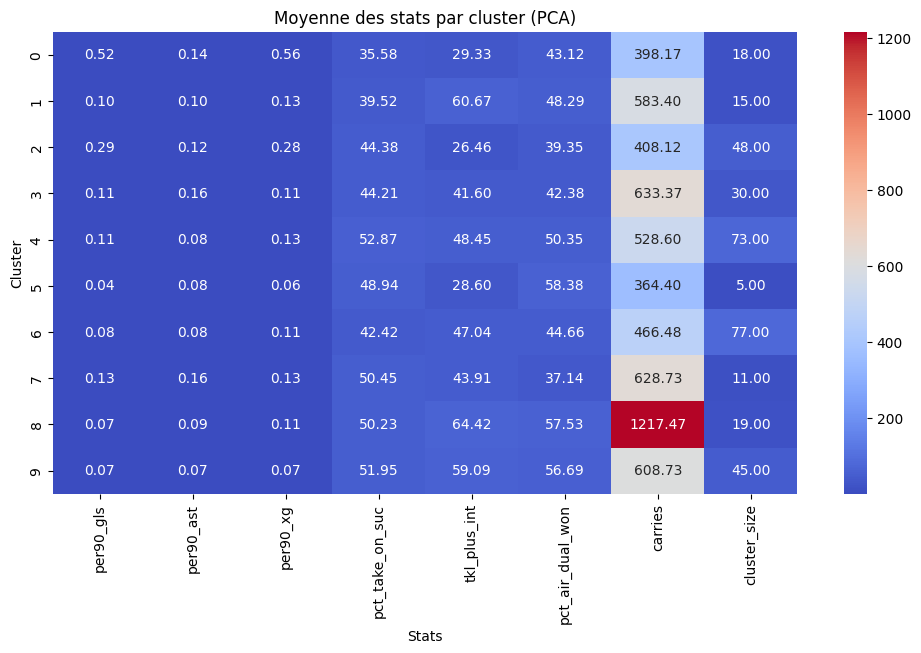

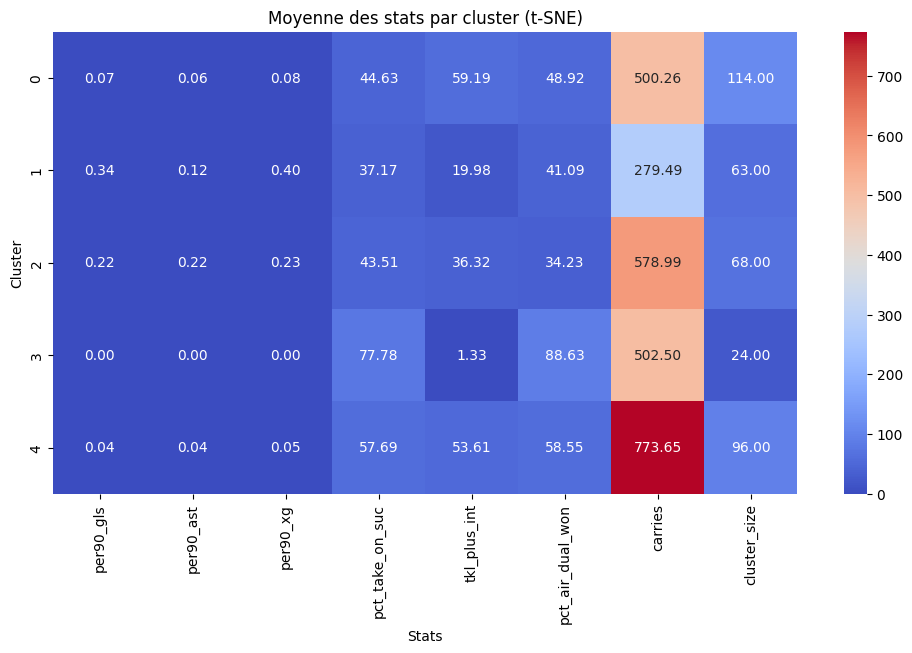

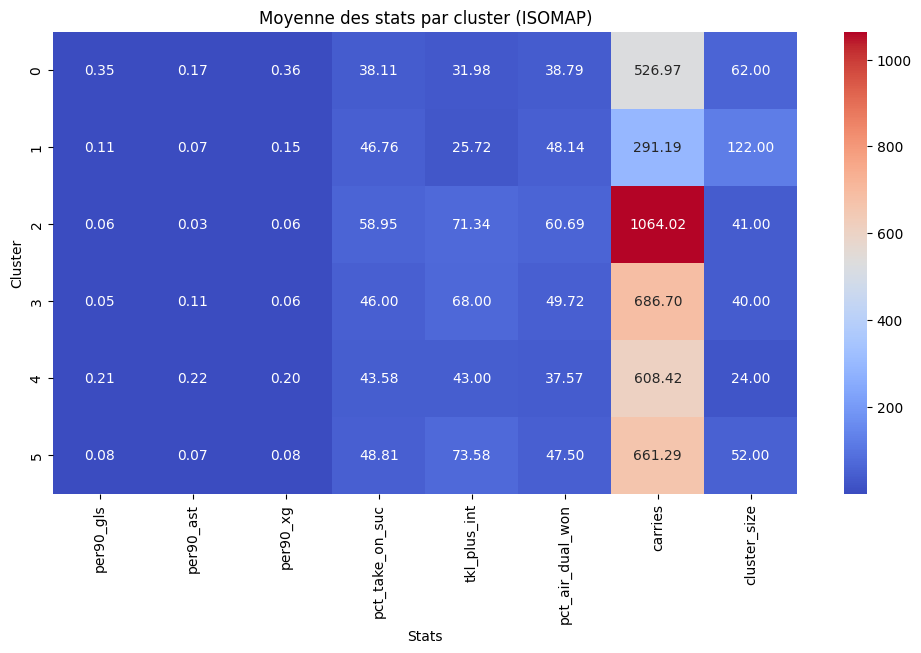

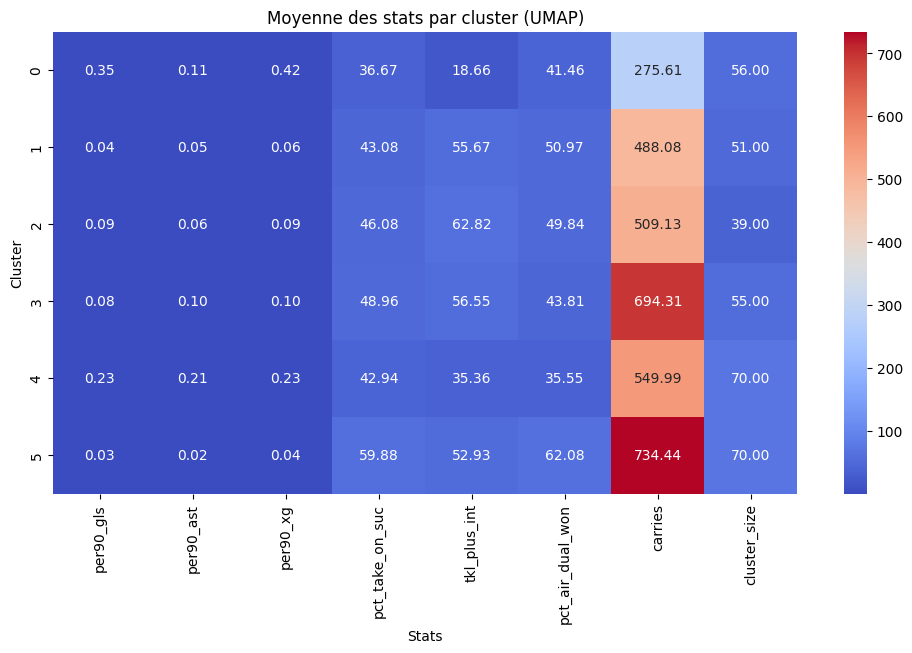

In [8]:
stats_cols = [
    'per90_gls',          # attaque
    'per90_ast',          # passes décisives
    'per90_xg',           # expected goals
    'pct_take_on_suc',    # dribbles réussis
    'tkl_plus_int',       # tacles + interceptions
    'pct_air_dual_won',   # duels aériens
    'carries'             # portées de balle
]

file_path_base = "../../raw_data/joueurs_ligue1_2024_2025.csv"
data_base= pd.read_csv(file_path_base, encoding="utf-8")

def plot_cluster_profiles(df_cluster, data_base, stats_cols, cluster_name="Cluster"):
    df_clusters = df_cluster[['player_name', 'cluster']].copy()
    df_stats = data_base[['player_name'] + stats_cols].copy()
    df_merged = pd.merge(df_clusters, df_stats, on='player_name', how='left')
    
    cluster_means = df_merged.groupby('cluster')[stats_cols].mean()
    cluster_sizes = df_merged.groupby('cluster').size().rename("cluster_size")
    
    cluster_means = cluster_means.copy()
    cluster_means['cluster_size'] = cluster_sizes

    
    plt.figure(figsize=(12,6))
    sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Moyenne des stats par cluster ({cluster_name})")
    plt.ylabel("Cluster")
    plt.xlabel("Stats")
    plt.show()
    
    return cluster_means
    
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X,
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters GMM sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

def print_results_3d(X, column1, column2, column3, data_name):
    fig = px.scatter_3d(
        X,
        x=column1,
        y=column2,
        z=column3,
        color='cluster',
        hover_data=['player_name', 'positions'],  # info au survol
        title=f"Clusters GMM sur données {data_name} (3D)",
        width=900,
        height=700,
        color_discrete_sequence=None
    )
    fig.show()

"""
print("="*60)
print("============RESULTS EN 2D===============")
print("="*60)
print_results(X_gmm_PCA_best, "PCA_1", "PCA_2", "PCA")
print_results(X_gmm_tSNE_best, "tsne_1", "tsne_2", "t-SNE")
print_results(X_gmm_ISOMAP_best, "isomap_1", "isomap_2", "ISOMAP")
print_results(X_gmm_UMAP_best, "UMAP_1", "UMAP_2", "UMAP")
"""

print("="*60)
print("============RESULTS EN 3D===============")
print("="*60)
print_results_3d(X_gmm_PCA_best, "PCA_1", "PCA_2", "PCA_3", "PCA")
cluster_profiles_PCA = plot_cluster_profiles(X_gmm_PCA_best, data_base, stats_cols, "PCA")
print_results_3d(X_gmm_tSNE_best, "tsne_1", "tsne_2", "tsne_3", "t-SNE")
cluster_profiles_PCA = plot_cluster_profiles(X_gmm_tSNE_best, data_base, stats_cols, "t-SNE")
print_results_3d(X_gmm_ISOMAP_best, "isomap_1", "isomap_2", "isomap_3", "ISOMAP")
cluster_profiles_ISOMAP = plot_cluster_profiles(X_gmm_ISOMAP_best, data_base, stats_cols, "ISOMAP")
print_results_3d(X_gmm_UMAP_best, "UMAP_1", "UMAP_2", "UMAP_3", "UMAP")
cluster_profiles_UMAP = plot_cluster_profiles(X_gmm_UMAP_best, data_base, stats_cols, "UMAP")